# Area2_Bump Dataset

## 1 Overview

The Area2_Bump dataset consists of data from a single recording session of a macaque performing center-out reaches with perturbations, with neural activity recorded from the somatosensory cortex. This data was provided by Raeed Chowdhury and Lee Miller at Northwestern University, and you can read more about the experiment design and data collection in their [paper](https://elifesciences.org/articles/48198) (Chowdhury et al. 2020).

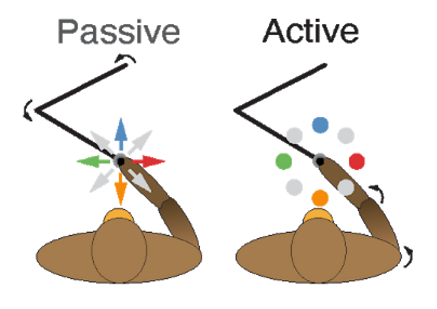

In [1]:
from IPython.display import display, Image
display(Image(filename="img/area2.png", embed=True))

### 1.1 Task

The bump task is similar to a standard delayed center-out reaching task, with the monkey using a manipulandum to direct a cursor from the center of a display to one of eight targets. However, on about half of the trials, the manipulandum bumped the monkey's arm in the direction of one of the targets, forcing the monkey to correct and return the cursor to the center. We call these trials passive trials, while normal trials without bumps are referred to as active trials. This task design allows for the examination of neural activity in response to both predictable and unpredictable sensory feedback.

### 1.2 Data

During the experiment, neural activity was recorded from Brodmann's area 2 of the somatosensory cortex. Area 2 is known to encode information about kinematics of the entire arm and is robustly driven by mechanical perturbations to the arm. The neural recordings were spike sorted offline, resulting in the provided single-unit spike times. In addition to neural data, the position of the monkey's hand, cursor position, force applied to the manipulandum, and hand velocity were recorded during the experiment. Motion tracking data from the experiment was also used to calculate joint angle and velocity and muscle length and velocity of the various joints and muscles of the monkey's arm.

## 2 Exploring the data

### 2.1 Setup

First, let's make the necessary imports and load the dataset.

In [2]:
## Imports

# %matplotlib widget
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
## Load data
dataset = NWBDataset("/snel/home/fpei/lvm/code/dandi/000127/sub-Han/", "*train", split_heldout=False)

### 2.2 Continuous data

The continuous data provided in the dataset includes:
* `force` - forces and torques applied to the manipulandum. `x`, `y`, and `z` are the forces applied in their respective directions, while `xmo`, `ymo`, and `zmo` are the torques in those directions
* `hand_pos` - x and y position of the hand, in cm
* `hand_vel` - x and y velocity of the hand, in cm/s
* `joint_ang` - angle of various monkey arm joints, in degrees
* `joint_vel` - velocity of various monkey arm joints, in degrees/s
* `muscle_len` - length of various monkey arm muscles, in m
* `muscle_vel` - velocity of various monkey arm muscles, in m/s
* `spikes` - spike trains binned at 1 ms

In [4]:
## View 'dataset.data'
dataset.data

signal_type                force                                          \
channel                        x       xmo         y       ymo         z   
clock_time                                                                 
0 days 00:00:00         0.111601 -0.016411 -0.016132  0.031638 -0.860530   
0 days 00:00:00.001000  0.112149 -0.016385 -0.016735  0.031656 -0.863162   
0 days 00:00:00.002000  0.112128 -0.016337 -0.017959  0.031570 -0.867022   
0 days 00:00:00.003000  0.112120 -0.016303 -0.019839  0.031548 -0.875458   
0 days 00:00:00.004000  0.112348 -0.016271 -0.021298  0.031409 -0.878765   
...                          ...       ...       ...       ...       ...   
0 days 00:37:03.314000  0.109535  0.015883 -0.358220 -0.038800  0.325109   
0 days 00:37:03.315000  0.103208  0.014566 -0.344428 -0.039158  0.283674   
0 days 00:37:03.316000  0.112367  0.014230 -0.341114 -0.037992  0.238139   
0 days 00:37:03.317000  0.134583  0.014858 -0.348047 -0.035429  0.189791   
0 days 00:37:03.318000  0.159886  0.015918 -0.357272 -0.032395  0.142843   

signal_type                       hand_pos             hand_vel            \
channel                      zmo         x         y          x         y   
clock_time                                                                  
0 days 00:00:00        -0.019057 -0.718481 -0.646707   0.121506 -0.913109   
0 days 00:00:00.001000 -0.019053 -0.718354 -0.647619   0.134653 -0.910121   
0 days 00:00:00.002000 -0.019009 -0.718212 -0.648527   0.150593 -0.904744   
0 days 00:00:00.003000 -0.018959 -0.718053 -0.649428   0.169150 -0.897144   
0 days 00:00:00.004000 -0.018881 -0.717874 -0.650321   0.190097 -0.887522   
...                          ...       ...       ...        ...       ...   
0 days 00:37:03.314000  0.012868  5.166923  3.234832 -24.981190 -6.696567   
0 days 00:37:03.315000  0.012906  5.141971  3.228088 -24.920175 -6.787637   
0 days 00:37:03.316000  0.013054  5.117082  3.221257 -24.854795 -6.872403   
0 days 00:37:03.317000  0.013406  5.092261  3.214344 -24.784820 -6.949949   
0 days 00:37:03.318000  0.013792  5.067513  3.207357 -24.710058 -7.019430   

signal_type             ... spikes                                          \
channel                 ...   7801 8401 8501 8801 8901 9001 9101 9401 9501   
clock_time              ...                                                  
0 days 00:00:00         ...    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...    ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:37:03.314000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:37:03.315000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:37:03.316000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:37:03.317000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:37:03.318000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                  
channel                9601  
clock_time                   
0 days 00:00:00         0.0  
0 days 00:00:00.001000  0.0  
0 days 00:00:00.002000  0.0  
0 days 00:00:00.003000  0.0  
0 days 00:00:00.004000  0.0  
...                     ...  
0 days 00:37:03.314000  0.0  
0 days 00:37:03.315000  0.0  
0 days 00:37:03.316000  0.0  
0 days 00:37:03.317000  0.0  
0 days 00:37:03.318000  0.0  

[2223319 rows x 167 columns]

### 2.3 Trial metadata

The trial info dataframe has a number of fields containing information about each trial:
* `trial_id` - a number assigned to each trial during loading
* `start_time` - time when the trial begins
* `end_time` - time when the trial ends
* `result` - whether a trial was rewarded (R), aborted (A), incomplete (I), or failed (F)
* `ctr_hold` - the amount of time the monkey had to hold in the center before the reach
* `ctr_hold_bump` - whether there was a bump during the center hold period
* `bump_dir` - direction of the bump, in degrees. If there was no bump, `bump_dir` is `NaN`
* `target_on_time` - time of target presentation
* `target_dir` - direction to the target, in degrees
* `go_cue_time` - time of go cue
* `bump_time` - time of center hold bump, if there was one
* `move_time` - time of movement onset, either in response to the go cue for active trials or the center hold bump for passive trials
* `cond_dir` - `bump_dir` for passive trials and `target_dir` for active trials. Though it is redundant with information already in other fields, it is provided for convenience when filtering trials


In [5]:
## View 'dataset.trial_info'
dataset.trial_info

,trial_id,start_time,end_time,result,ctr_hold,ctr_hold_bump,bump_dir,target_on_time,target_dir,go_cue_time,bump_time,move_onset_time,cond_dir,split
0,0,0 days 00:00:00.502000,0 days 00:00:04.556000,R,1.106973,False,NaN,0 days 00:00:03.734000,45.0,0 days 00:00:03.735000,NaT,0 days 00:00:04.075000,45.0,val
1,1,0 days 00:00:05.059000,0 days 00:00:05.588000,A,1.344188,True,NaN,NaT,225.0,NaT,NaT,NaT,NaN,none
2,2,0 days 00:00:06.090000,0 days 00:00:09.374000,I,1.170550,True,225.0,0 days 00:00:08.369000,180.0,0 days 00:00:08.370000,0 days 00:00:07.905000,0 days 00:00:07.898000,225.0,none
3,3,0 days 00:00:09.877000,0 days 00:00:15.298000,R,1.222202,False,NaN,0 days 00:00:14.318000,45.0,0 days 00:00:14.319000,NaT,0 days 00:00:14.656000,45.0,train
4,4,0 days 00:00:15.800000,0 days 00:00:17.005000,A,0.777271,False,NaN,NaT,135.0,NaT,NaT,NaT,135.0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,821,0 days 00:36:47.267000,0 days 00:36:50.252000,R,0.951575,True,180.0,0 days 00:36:49.650000,135.0,0 days 00:36:49.651000,0 days 00:36:48.732000,0 days 00:36:48.727000,180.0,train
822,822,0 days 00:36:50.755000,0 days 00:36:53.966000,R,1.031749,False,NaN,0 days 00:36:53.272000,45.0,0 days 00:36:53.273000,NaT,0 days 00:36:53.584000,45.0,train
823,823,0 days 00:36:54.469000,0 days 00:36:56.661000,R,0.585132,True,315.0,0 days 00:36:56.018000,45.0,0 days 00:36:56.019000,0 days 00:36:55.546000,0 days 00:36:55.561000,315.0,train
824,824,0 days 00:36:57.163000,0 days 00:37:00.370000,I,1.283537,True,180.0,0 days 00:36:59.365000,225.0,0 days 00:36:59.366000,0 days 00:36:58.641000,0 days 00:36:58.641000,180.0,none


### 2.4 Reach conditions

To help visualize the task, we will first plot all of the reaches in the dataset, colored by condition.

In [6]:
## Optional resampling
# It may be beneficial to resample the data before you proceed to the analysis sections,
# as they may be fairly memory-intensive. However, we have not tested this notebook at bin sizes
# of over 20 ms, so we cannot guarantee that everything will work as intended at
# those larger bin sizes.
dataset.resample(5)

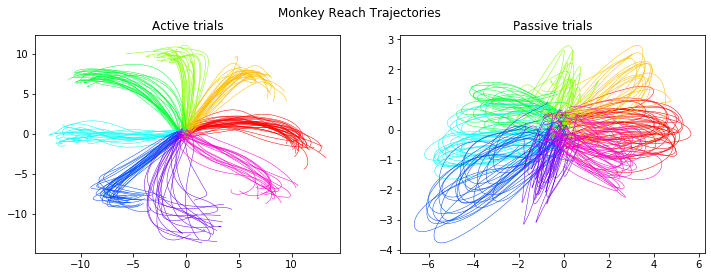

In [7]:
# All 16 conditions, in the format (ctr_hold_bump, cond_dir)
unique_conditions = [(False, 0.0), (False, 45.0), (False, 90.0), (False, 135.0),
                     (False, 180.0), (False, 225.0), (False, 270.0), (False, 315.0),
                     (True, 0.0), (True, 45.0), (True, 90.0), (True, 135.0),
                     (True, 180.0), (True, 225.0), (True, 270.0), (True, 315.0)]

# Initialize figure
fig = plt.figure(figsize=(12, 4))
ax_act = fig.add_subplot(1, 2, 1)
ax_pas = fig.add_subplot(1, 2, 2)

# Loop through conditions
for cond in unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (np.all(dataset.trial_info[['ctr_hold_bump', 'cond_dir']] == cond, axis=1)) & \
                (dataset.trial_info.split != 'none')
    # Extract relevant portion of selected trials
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100, 500), ignored_trials=~cond_mask)
    # Plot reaches on appropriate subplot
    for idx, trial in cond_data.groupby('trial_id'):
        if cond[0]: # Passive trials
            ax_pas.plot(trial.hand_pos.x, trial.hand_pos.y, color=plt.cm.hsv(cond[1] / 360), linewidth=0.5)
        else: # Active trials
            ax_act.plot(trial.hand_pos.x, trial.hand_pos.y, color=plt.cm.hsv(cond[1] / 360), linewidth=0.5)

# Add labels
ax_act.set_title('Active trials')
ax_pas.set_title('Passive trials')
fig.suptitle(f'Monkey Reach Trajectories')
plt.show()

As described earlier, active trials are simply standard center-out reaches, while passive trials consist of a bump outward and a corrective movement back to the center hold.

### 2.5 Single-neuron responses

The bump task involves two different types of trials: active, where the subject simply reaches toward the target, and passive, where the subject's arm is perturbed before the reach. In addition, the reaches and bumps can occur in one of eight directions. This results in a total of 16 different trial conditions, each with unique neuron firing rate profiles. Below, we'll plot the PSTHs of a single neuron for each of the 16 conditions. Feel free to try plotting different neurons.

ValueError: x and y must have same first dimension, but have shapes (1,) and (120, 1)

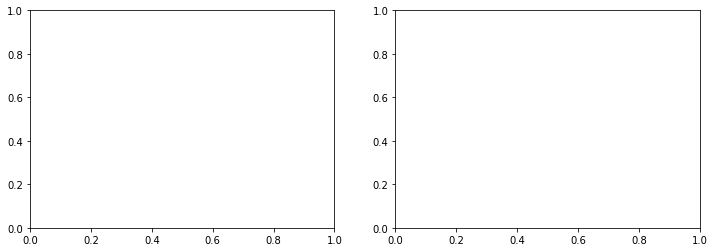

In [8]:
## Plot PSTH

# Smooth spikes with 30 ms std Gaussian kernel
dataset.smooth_spk(30, name='smth_30')

# plot PSTHs for neuron 1001
neur_num = 1001

# All 16 conditions, in the format (ctr_hold_bump, cond_dir)
unique_conditions = [(False, 0.0), (False, 45.0), (False, 90.0), (False, 135.0),
                     (False, 180.0), (False, 225.0), (False, 270.0), (False, 315.0),
                     (True, 0.0), (True, 45.0), (True, 90.0), (True, 135.0),
                     (True, 180.0), (True, 225.0), (True, 270.0), (True, 315.0)]

# Initialize figure
fig = plt.figure(figsize=(12, 4))
ax_act = fig.add_subplot(1, 2, 1)
ax_pas = fig.add_subplot(1, 2, 2, sharex=ax_act, sharey=ax_act)

# Loop through conditions
for cond in unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (np.all(dataset.trial_info[['ctr_hold_bump', 'cond_dir']] == cond, axis=1)) & \
                (dataset.trial_info.split != 'none')
    # Extract relevant portion of selected trials
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100, 500), ignored_trials=~cond_mask)
    # Align and average data across trials
    cond_psth = cond_data.groupby('align_time')[[('spikes_smth_30', neur_num)]].mean().to_numpy() / dataset.bin_width * 1000
    # Plot on appropriate subplot
    if cond[0]: # Passive trials
        ax_pas.plot(np.arange(-100, 500, dataset.bin_width), cond_psth, label=cond[1])
    else: # Active trials
        ax_act.plot(np.arange(-100, 500, dataset.bin_width), cond_psth)

# Add labels
ax_act.set_xlim(-100, 500)
ax_act.set_ylim(0)
ax_act.set_xlabel('Time after move onset (ms)')
ax_pas.set_xlabel('Time after arm bump (ms)')
ax_act.set_ylabel('Firing rate (spk/s)')
ax_pas.set_ylabel('Firing rate (spk/s)')
ax_act.set_title('Active trials')
ax_pas.set_title('Passive trials')
fig.legend(title='target dir or\nbump dir')
fig.suptitle(f'Neuron {neur_num} PSTH')
plt.show()

Neuron 1001 appears to be most active during bumps or reaches to the upper right, since that condition (45&deg;) and the next closest conditions (0&deg; and 90&deg;) have the largest peaks in firing rate around movement onset or bump delivery. Also note the conditions in which there is a delayed increase in the neuron's activity during passive trials: 180&deg;, 225&deg;, and 270&deg;. These conditions result in a corrective movement in the 0&deg;, 45&deg;, and 90&deg; directions, respectively, which may be the reason for the observed activity.

Not all neurons are so clearly tuned to certain stimuli, however, and many have far more complex or inconsistent PSTHs that are difficult to interpret and analyze. Instead of trying to gain insight from individual neurons, we can use the activity of the recorded neural population to extract information about the stimulus.

### 2.6 Decoding hand kinematics

Since area 2 receives sensory input from the arm, its activity should encode information about the movement of the hand. To test this, we will try to decode hand velocity from firing rate estimates generated using spike smoothing.

Due to the different nature of active and passive trials, we will use separate decoders for the two trial types. We will also lag neural activity relative to hand velocity, as sensory feedback takes some time to travel from the arm to the brain. Our lag value of 40 ms is where we typically have seen the best results, but feel free to vary that value and the std of the Gaussian kernal.

In [ ]:
## Helper function for training decoder

def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field='spikes_smth_50', y_field='hand_vel'):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    # Fit decoder and predict kinematics
    lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    lr.fit(rates_df[x_field].to_numpy(), vel_df[y_field].to_numpy())
    print(f"Decoding R2: {lr.best_score_}")
    pred_vel = lr.predict(rates_df[x_field].to_numpy())
    # Concatenate to extracted kinematics data
    vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    return vel_df

In [ ]:
## Kinematic decoding

# Choose lag value
lag = 40
# Smooth spikes with 50 ms std Gaussian
dataset.smooth_spk(50, name='smth_50', ignore_nans=True) # `ignore_nans` prevents NaNs from propagating during convolution
# Filter active or passive trials
active_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
# Train decoders and predict velocity
act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', (-100, 500), lag)
pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', (-100, 500), lag)

Decoding R2: 0.7071375475683622
Decoding R2: 0.6028276836924169


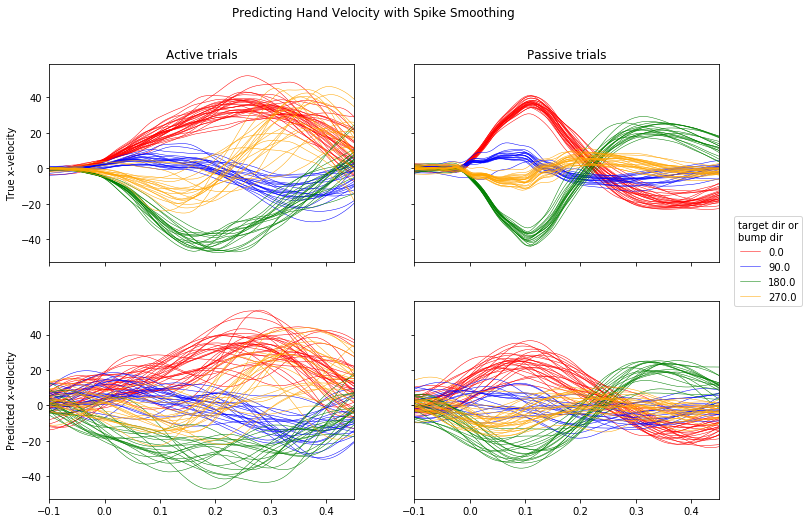

In [ ]:
## Plot predicted vs. true kinematics

# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(np.arange(-100, 500, dataset.bin_width), trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(np.arange(-100, 500, dataset.bin_width), trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(np.arange(-100, 500, dataset.bin_width), trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(np.arange(-100, 500, dataset.bin_width), trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(-100, 450)
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
fig.suptitle('Predicting Hand Velocity with Spike Smoothing')
plt.show()

As expected, rates inferred by spike smoothing are able to decode general trends in hand velocity, achieving R2's of around 0.7 for active trials and 0.6 for passive trials. However, it is clear from the plots that the predicted velocities are not particularly accurate on a single-trial basis.

### 2.7 Neural trajectories

Finally, let's see how the population activity evolves over time during each of the 16 conditions. We'll estimate average firing rates of each neuron per condition, apply PCA separately to active and passive conditions and plot the resulting trajectories.

In [ ]:
## Computing trial-averaged firing rates

# All 16 conditions, in the format (ctr_hold_bump, cond_dir)
unique_conditions = [(False, 0.0), (False, 45.0), (False, 90.0), (False, 135.0),
                     (False, 180.0), (False, 225.0), (False, 270.0), (False, 315.0),
                     (True, 0.0), (True, 45.0), (True, 90.0), (True, 135.0),
                     (True, 180.0), (True, 225.0), (True, 270.0), (True, 315.0)]

# Loop through conditions to get firing rates
act_psth_list = []
pas_psth_list = []
for cond in unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (np.all(dataset.trial_info[['ctr_hold_bump', 'cond_dir']] == cond, axis=1)) & \
                (dataset.trial_info.split != 'none')
    # Extract relevant portion of selected trials
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100, 500), ignored_trials=~cond_mask)
    # Align and average data across trials
    cond_psth = cond_data.groupby('align_time').mean()['spikes_smth_50'].to_numpy() / dataset.bin_width * 1000
    # Append to appropriate list
    if cond[0]:
        pas_psth_list.append(cond_psth)
    else:
        act_psth_list.append(cond_psth)

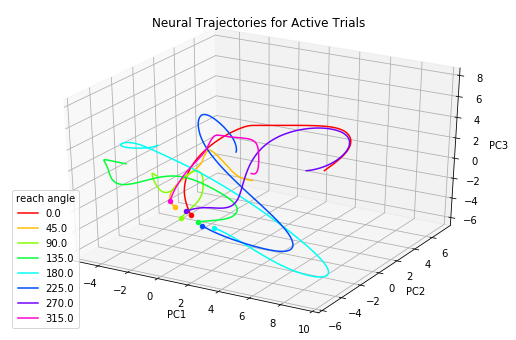

In [ ]:
## Extracting and plotting trajectories for active trials

# First 8 conditions in `unique_conditions` are active
active_conditions = unique_conditions[:8]

# Stack data, scale, and apply PCA
psth_stack = np.vstack(act_psth_list)
psth_scaled = StandardScaler().fit_transform(psth_stack)
pca = PCA(n_components=3)
traj_stack = pca.fit_transform(psth_scaled)

# Reshape data to 3d: condition x time x pca_dims
traj_arr = traj_stack.reshape((len(active_conditions), len(act_psth_list[0]), -1))

# Plot trajectories
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for traj, cond in zip(traj_arr, active_conditions):
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=(cond[1]), color=(plt.cm.hsv(cond[1] / 360)))
    ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], color=(plt.cm.hsv(cond[1] / 360))) # mark trajectory start

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='reach angle', loc='lower left')
plt.title('Neural Trajectories for Active Trials')
plt.show()

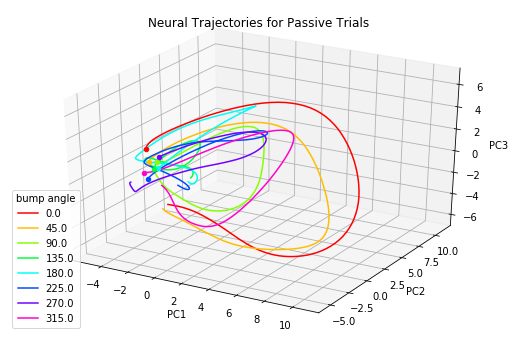

In [ ]:
## Extracting and plotting trajectories for passive trials

# Last 8 conditions in `unique_conditions` are passive
passive_conditions = unique_conditions[8:]

# Stack data, scale, and apply PCA
psth_stack = np.vstack(pas_psth_list)
psth_scaled = StandardScaler().fit_transform(psth_stack)
pca = PCA(n_components=3)
traj_stack = pca.fit_transform(psth_scaled)

# Reshape data to 3d: condition x time x pca_dims
traj_arr = traj_stack.reshape((len(passive_conditions), len(pas_psth_list[0]), -1))

# Plot trajectories
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for traj, cond in zip(traj_arr, passive_conditions):
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=(cond[1]), color=(plt.cm.hsv(cond[1] / 360)))
    ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], color=(plt.cm.hsv(cond[1] / 360))) # mark trajectory start

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='bump angle', loc='lower left')
plt.title('Neural Trajectories for Passive Trials')
plt.show()

The different conditions in both active and passive trials seem to have distinct trajectories. As one might expect, conditions with reaches or bumps in similar directions (e.g. 0&deg; and 45&deg;) tend to have closer trajectories than those with very different reach or bump directions. Also interesting to note is that active trajectories end at various places in the 3d subspace, just like the center-out reaches, while passive trajectories tend to return close to their initial positions, similar to corrective movements in response to arm perturbation.

## 3 Summary

In this notebook, we:
* introduced the Area2_Bump dataset, describing the task and the data collected
* looked at what specific continuous and trial data is included
* demonstrated the task by plotting individual reaches
* explored single-neuron responses by plotting PSTHs for each condition
* evaluated how accurately population activity estimated by spike smoothing can decode hand velocity
* visualized the timecourse of neural population activity by extracting trial-averaged neural trajectories with PCA

*Todo: brief sentence(s) emphasizing value of the dataset*